# Working with data

### In PySprint currently 4 different evaluating methods are supported: 
* Minimum - maximum method
* Cosine fit method
* Stationary phase point method
* Fouier-transform method 

PySprint API provides a basic *Dataset* class for all of the methods. This shouldn't be used explicitly by the user.

Let's say you want to use the **Cosine function fit method** (CFF for short) on a spectrogram. First, let's generate data.  

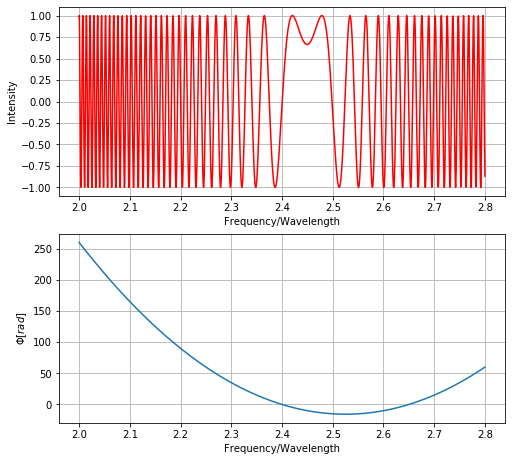

In [2]:
%matplotlib inline

from pysprint import Generator, CosFitMethod

myspectr = Generator(2, 2.8, 2.4, delay = 150, GD = -250, GDD = 2000, normalize = True)
myspectr.generate_freq()
myspectr.phase_graph()

In [3]:
#unpacking the generated data
x, y, ref, sam = myspectr.unpack()

#Feed it into CosFitMethod class
mycosfit = CosFitMethod(x, y, ref, sam)

Cosine fit method is really sensitive to initial parameters. Most of the time leaving all parameters default will result to inaccurate fitting. Parameters can be accessed via *object.params*. It is always a 8-length list with the following parameters: $$[c_0, c_1, b_0, b_1, b_2, b_3, b_4, b_5]$$

$$ c_0 + c_1 \cdot cos (b_0 + b_1\cdot x + b_2\cdot x^2+ b_3\cdot x^3+ b_4\cdot x^4+ b_5\cdot x^5)$$

In this example, I will modify the defaults:
We assume there's no higher order dispersion than GDD and we will try to fit the following:
$$\ c_0 + c_1 \cdot cos (b_0 + b_1\cdot x + b_2\cdot x^2)$$
Do achieve it, CosFitMethod has built in methods:

In [4]:
#guess the dispersion
mycosfit.guess_GD(-250)
mycosfit.guess_GDD(2000)
#restrict maximum dispersion order
mycosfit.set_max_order(2)

If everything's set, we are ready to use the *calculate* method. (By the way, all methods work like this.)

In [5]:
#by calling the calculate method on any method, the parameters immediately printed and also returned
dispersion, dispersion_std, fit_report = mycosfit.calculate(reference_point = 2.45)

GD = -229.79590134706842 +/- 0 fs^1
GDD = 2047.7698682393918 +/- 0 fs^2
TOD = 0 +/- 0 fs^3
FOD = 0 +/- 0 fs^4
QOD = 0 +/- 0 fs^5


Of course we want to see how good the fit was, and modify the initial parameters if it's inaccurate.
This can be achieved with *plot_result* method.

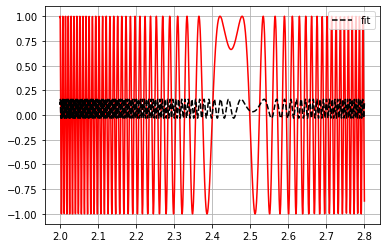

In [6]:
mycosfit.plot_result() # the fit fails, parameters need to be tweaked.

Let's generate another spectrogram for **Fourier method**.  It doesn't require the spectrum to be normalized and we need higher delay. 

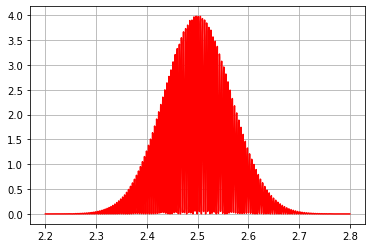

In [27]:
h = Generator(2.2, 2.8, 2.5, delay = 1500, GDD = -500, TOD = 3000, FOD = -20000, pulseWidth = 25)
h.generate_freq()
a, b = h.unpack()

from pysprint import FFTMethod

myfourier = FFTMethod(a,b)
myfourier.show()

We will perform IFFT, then cut the valuable part and FFT back:

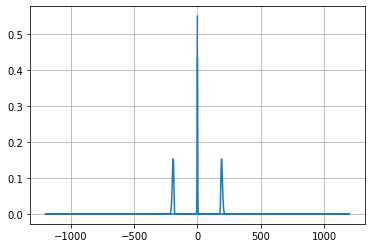

In [28]:
myfourier.ifft()
myfourier.show()

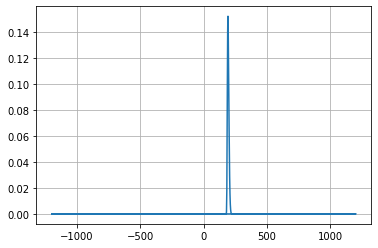

In [29]:
myfourier.cut(at = 200, std = 40)
myfourier.show()

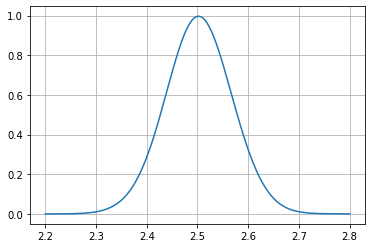

In [30]:
myfourier.fft()
myfourier.show()

Now, we specify the fit order and reference_point, then calculate:

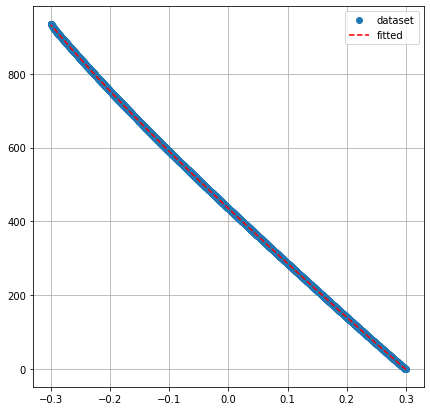

GD = -1511.3385609311 +/- 0.08683399855202495 fs^1
GDD = 496.3332833943933 +/- 1.5583048996911526 fs^2
TOD = -2858.4450539763898 +/- 8.841967342064239 fs^3
FOD = 23730.425824206868 +/- 232.07838502290485 fs^4
QOD = 0 +/- 0 fs^5


In [31]:
dispersion, dispersion_std, fit_report = myfourier.calculate(fit_order = 4, reference_point = 2.5, show_graph = True)

**Minimum-maximum method**:

For minimum maximum method we need a good peak detection algorithm. PySprint has some built-in tools for that, but also you can manually pass min and max x values to the function.

We will use the first dataset for this method. 

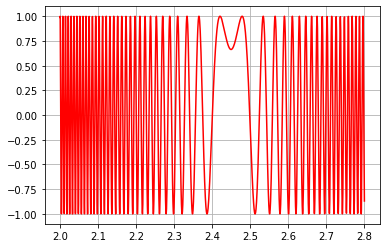

In [34]:
from pysprint import MinMaxMethod

mymm = MinMaxMethod(x, y, ref, sam)
mymm.show()

We will use the *detect_peak* method for now.

In [37]:
max_x, max_y, min_x, min_y = mymm.detect_peak(pmax = 0.01, pmin = 0.01, threshold = 0.4)

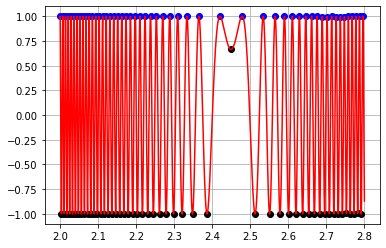

In [38]:
#plotting the mins as black dots, maxs as blue dots
mymm.plotwidget.plot(max_x, max_y, 'bo')
mymm.plotwidget.plot(min_x, min_y, 'ko')
mymm.show()

For the Minimum - maximum method we need the x coordinates. We pass them to the created class, then we use the *calculate* method.
The maximums can be passed via *object.xmax*, minimums via *object.xmin*. (We don't need the y coordinates for calculation, that's only for plotting.)

In [39]:
mymm.xmax = max_x
mymm.xmin = min_x

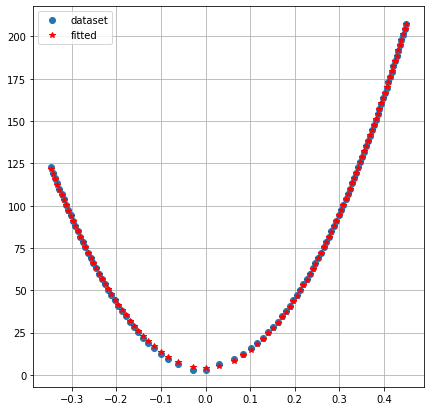

GD = 4.57809193417722 +/- 0.2154054747023417 fs^1
GDD = 1991.2516371131628 +/- 2.1275753150880776 fs^2
TOD = 0 +/- 0 fs^3
FOD = 0 +/- 0 fs^4
QOD = 0 +/- 0 fs^5


In [40]:
dispersion, disperson_std, fit_report = mymm.calculate(reference_point = 2.45, fit_order = 2, show_graph = True)

Lastly: **Stationary phase point method** (SPP for short). This method is not quite good as in the GUI: Basically it's a curve fitting function which calculates dispersion from the parameters.

In [41]:
from pysprint import SPPMethod

#always use the 'from_raw' constructor, it allows to pass matching pairs of data (unlike in the GUI)
dlys = [1,2,3,4,5,6]
fr = [10,20,30,40,50,60]
myspp = SPPMethod.from_raw(fr, dlys)

With SPP-Method x and y values have a different meaning compared to other methods.
		Make sure you put delays to y and frequencies to x:
				SPPMethod(frequencies, delays)


In [43]:
dispersion, dispersion_std, fit_report = myspp.calculate(reference_point = 30, fit_order = 1)

GD = 3.0 +/- 4.722721986012807e-17 fs^1
GDD = 0.09999999999999999 +/- 2.653940669489085e-18 fs^2
TOD = 0 +/- 0 fs^3
FOD = 0 +/- 0 fs^4
QOD = 0 +/- 0 fs^5


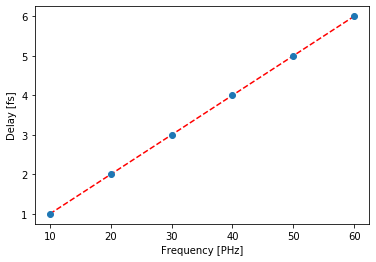

In [44]:
myspp.plotwidget.xlabel('Frequency [PHz]')
myspp.plotwidget.ylabel('Delay [fs]')
myspp.plot_result()

### Accessing the GUI

You can run the GUI with the loaded data from any Dataset or Generator object in the following way:

In [ ]:
#mymm is a PySprint.MinMaxMethod object. To open the app with the initialized data, use:
mymm.open_app()